In [1]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torchvision
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import math
import torch.nn.functional as F
import pandas as pd

def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(34)

In [2]:
df_train = pd.read_csv('../data/toydata/train_data.csv')
df_val = pd.read_csv('../data/toydata/val_data.csv')
df_test = pd.read_csv('../data/toydata/test_data.csv')

x_train, y_train = df_train['x'].values, df_train['y'].values
x_val, y_val = df_val['x'].values, df_val['y'].values
x_test, y_test, line = df_test['x'].values, df_test['y'].values, df_test['line'].values




In [3]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

def collate_fn(batch):

    x, y = zip(*batch)

    return torch.tensor(x)[:,None], torch.tensor(y)

In [4]:
# seed workers for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# g = torch.Generator()
# g.manual_seed(0)

traindata = ToyDataset(x_train, y_train)
trainloader = DataLoader(traindata, batch_size=500, shuffle=True, collate_fn=collate_fn, drop_last=True, pin_memory=True)

valdata = ToyDataset(x_val, y_val)
valloader = DataLoader(valdata, batch_size=500, shuffle=True, collate_fn=collate_fn, drop_last=True, pin_memory=True)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=len(y_test), shuffle=False, collate_fn=collate_fn, pin_memory=True)

NUM_BATCHES = len(trainloader)

We use a diagonal Gaussian distribution (zero covariance) as the variational posterior. Rather than using just $\mu$ and $\sigma$ as the variational parameters, the standard deviation is parameterised as:
$$
\sigma = \log{(1 + \exp{(\rho)})}
$$
such that $\sigma$ is always non-negative. The variational parameters are then $\mathbf{\theta} = (\mu, \rho)$. 

The code blocks in the following sections are inspired by:

https://github.com/nitarshan/bayes-by-backprop/blob/master/Weight%20Uncertainty%20in%20Neural%20Networks.ipynb
https://colab.research.google.com/drive/1K1I_UNRFwPt9l6RRkp8IYg1504PR9q4L#scrollTo=ASGi2Ecx5G-F


In [5]:
class Gaussian():
    def __init__(self, mu, rho, device='cpu'):
        self.device = device
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(torch.tensor(0.0).to(self.device), torch.tensor(1.0).to(self.device))
        
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))

    def rsample(self):
        epsilon = self.normal.sample(self.rho.size()) 
        return self.mu + self.sigma * epsilon

    def log_prob(self, w):
        return self.normal.log_prob(w).sum()


The ``Gaussian`` class is a simple class that allows us to sample from a Gaussian distribution, representing the variational posterior.

The function ``sigma`` computes the standard deviation $\sigma$ for a given $\rho$ value.
The function ``sample`` allows us to sample from the approximate posterior, using the reparametrisation trick with $\mu$ and $\sigma$. 
The function ``log_prob`` computes the log-probability density function for a normal distribution wtih mean $\mu$ and standard devation $\sigma$ (derivation below):

The probability density function for the weights $\mathbf{w}$ given the variational parameters $\mathbf{\theta} = (\mu, \rho)$ of a Gaussian distribution is given as
\begin{align*}
q(\mathbf{w|\mathbf{\theta}}) &= \prod_j \mathcal{N}(w_j | \mu, \sigma) \\
& = \prod_j \frac{1}{\sigma \sqrt{(2\pi)}} \exp{-\frac{1}{2} \left( \frac{w_j - \mu}{\sigma}    \right)^2}
\end{align*}
Then taking the log, we get:
\begin{align*}
\log{q(\mathbf{w}|\mathbf{\theta})} &=  \log{  \left( \prod_j \frac{1}{\sigma \sqrt{(2\pi)}} \exp{-\frac{1}{2} \left( \frac{w_j - \mu}{\sigma}    \right)^2} \right)} \\
           &= \sum_j \log{(1)} - \log{\left(\sigma \sqrt(2 \pi)\right) - \frac12 \left( \frac{w_j - \mu}{\sigma} \right)^2 } \\
           &= \sum_j -\log{(\sigma)} - \frac12 \log{(2\pi)} - \frac12 \left( \frac{w_j - \mu}{\sigma} \right)^2
\end{align*}

The prior that was proposed in the paper by Blundell et al. is a Gaussian mixture prior over the weights $\mathbf{w}$. 
$$
P(\mathbf{w}) = \prod_j \pi \mathcal{N}(w_j|0, \sigma_1^2) + (1-\pi) \mathcal{N}(w_j| 0, \sigma_2^2) 
$$
where $\pi \in [0,1]$ is the mixture weight.

In [6]:
class ScaleMixturePrior():
    def __init__(self, pi=0.5, sigma1=torch.exp(torch.tensor(0)), sigma2=torch.exp(torch.tensor(-6)), device='cpu'):
        self.device = device
        self.pi = pi
        self.mu = 0
        self.sigma1 = sigma1
        self.sigma2 = sigma2

    def prob(self, w, sigma):
    
        return (1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi)))) * torch.exp(-0.5 * torch.pow((w - self.mu), 2) / torch.pow(sigma, 2))

    def log_prob(self, w):
        prob1 = self.prob(w, self.sigma1)
        prob2 = self.prob(w, self.sigma2)

        return torch.log(self.pi * prob1 + (1 - self.pi) * prob2).sum()

We visualise the scale mixture prior below with $\sigma_1 = \exp(0)$ and $\sigma_2 = \exp(-6)$

C:\Users\Yucheng\AppData\Local\Temp\ipykernel_18052\2271797949.py:2: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:85.)
  SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])


[0.39894226] [157.70288] 79.05094


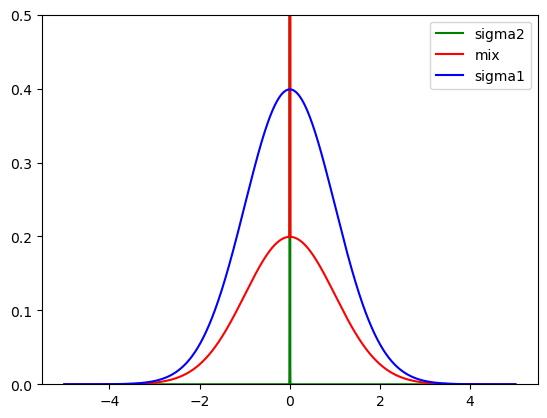

In [7]:
PI = 0.5
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixturePrior(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    d1 = np.array([torch.exp(normal_1.log_prob(torch.tensor(float(c)))).detach().cpu() for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(torch.tensor(float(c)))).detach().cpu() for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(torch.tensor(float(c)))).detach().cpu() for c in x_points])
    print(max(d1), max(d2), max(d3))
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)

    
visualize_scale_mixture_components()

We implement a Bayesian linear layer for our Bayesian neural network. 

In [8]:
class BayesianLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, pi=0.5, sigma1=torch.exp(torch.tensor(0)), sigma2=torch.tensor(0.3), device='cpu'):
        super().__init__()
        """
        """        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device

        # initialise mu and rho parameters so they get updated in backpropagation
        self.weight_mu = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(input_dim, output_dim).uniform_(-5, -4)) 
        self.bias_mu = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(output_dim).uniform_(-5, -4))

        # initialise priors
        self.weight_prior = ScaleMixturePrior(pi, sigma1, sigma2, device=device)
        self.bias_prior = ScaleMixturePrior(pi, sigma1, sigma2, device=device)

        # initialise variational posteriors
        self.weight_posterior = Gaussian(self.weight_mu, self.weight_rho, device=device)
        self.bias_posterior = Gaussian(self.bias_mu, self.bias_rho, device=device)

        self.log_prior = 0.0
        self.log_variational_posterior = 0.0

    def forward(self, x, inference=False):

        if inference:
            w = self.weight_posterior.mu
            b = self.bias_posterior.mu

            self.log_prior = 0.0
            self.log_variational_posterior = 0.0

        else:
            w = self.weight_posterior.rsample()
            b = self.bias_posterior.rsample()

            self.log_prior = self.weight_prior.log_prob(w) + self.bias_prior.log_prob(b)
            self.log_variational_posterior = self.weight_posterior.log_prob(w) + self.bias_posterior.log_prob(b)

        output = torch.mm(x, w) + b

        # print("layer:", w.device, b.device, output.device, self.log_prior.device, self.log_variational_posterior.device)
        
        return output


In [9]:
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, hidden_units1, hidden_units2, device="cpu"):
        super().__init__()
        """
        """
        self.layer1 = BayesianLinearLayer(1, hidden_units1, device=device)
        self.layer2 = BayesianLinearLayer(hidden_units1, hidden_units2, device=device)
        self.layer3 = BayesianLinearLayer(hidden_units2, 2, device=device)

        self.layers = [self.layer1, self.layer2, self.layer3]

        self.device = device

    def forward(self, x, inference=False):
        x = F.relu(self.layer1(x, inference))
        x = F.relu(self.layer2(x, inference))
        x = self.layer3(x, inference)

        mu = x[:, 0]
        rho = x[:, 1]

        return mu, rho

    def compute_log_prior(self):
        model_log_prior = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinearLayer):
                model_log_prior += layer.log_prior
        return model_log_prior

    def compute_log_variational_posterior(self):
        model_log_variational_posterior = 0.0
        for layer in self.layers:
            if isinstance(layer, BayesianLinearLayer):
                model_log_variational_posterior += layer.log_variational_posterior
       
        return model_log_variational_posterior
 
    
    def compute_NLL(self, mu, target, sigma):
        loss_fn = torch.nn.GaussianNLLLoss(reduction='sum', eps=1e-6)
        var = torch.pow(sigma, 2)
        NLL = loss_fn(mu, target, var)
        return NLL
    
    def get_sigma(self, rho):
        return torch.log1p(torch.exp(rho))

    def compute_ELBO(self, input, target, n_samples=1):

        log_priors = torch.zeros(n_samples) 
        log_variational_posteriors = torch.zeros(n_samples) 
        NLLs = torch.zeros(n_samples) 

        for i in range(n_samples):
            mu, rho = self.forward(input, inference=False)
            sigma = self.get_sigma(rho)
            log_priors[i] = self.compute_log_prior()
            log_variational_posteriors[i] = self.compute_log_variational_posterior()
            NLLs[i] = self.compute_NLL(mu, target, sigma)

        log_prior = log_priors.mean(0)
        log_variational_posterior = log_variational_posteriors.mean(0)
        NLL = NLLs.mean(0)

        loss = ((log_variational_posterior - log_prior) / NUM_BATCHES) + NLL

        return loss, log_prior, log_variational_posterior, NLL



In [10]:
# useful functions 🤖

def train_BNN(model, optimizer, trainloader, valloader, epochs=500, model_name='BNN', val_every_n_epochs=10, device='cpu'):
    
    if device == 'cpu':
        print("Training on CPU")
    else:
        print("Cuda available, training on GPU")


    losses = []
    log_priors = []
    log_variational_posteriors = []
    NLLs = []

    val_losses = []
    val_log_priors = []
    val_log_variational_posteriors = []
    val_NLLs = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            model.train()

            x_, y_ = x_.float().to(device), y_.float().to(device)

            optimizer.zero_grad()

            loss, log_prior, log_posterior, log_NLL = model.compute_ELBO(x_, y_)
            
            loss.backward(retain_graph=False)
            optimizer.step()

            losses.append(loss.item()) 
            log_priors.append(log_prior.item())
            log_variational_posteriors.append(log_posterior.item())
            NLLs.append(log_NLL.item()) 

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float().to(device), val_y.float().to(device)
                
                    val_loss, _ , _, _ = model.compute_ELBO(val_x, val_y)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, log_priors, log_variational_posteriors, NLLs, val_losses


def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    plt.show()


def plot_log_probs(log_priors, log_variational_posteriors, NLLs):

    fig, ax = plt.subplots(1,3, figsize=(18,6))

    ax[0].plot(log_priors, label='Train log prior')
    ax[0].set_title('Train log prior')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Log prior')

    ax[1].plot(log_variational_posteriors, label='Train log variational posterior', color='orange')
    ax[1].set_title('Train log variational posterior')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Log variational posterior')

    ax[2].plot(NLLs, label='Train NLL', color='green')
    ax[2].set_title('Train NLL')
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('NLL')

    plt.show()

Training on CPU


  0%|          | 0/10000 [00:00<?, ?it/s]

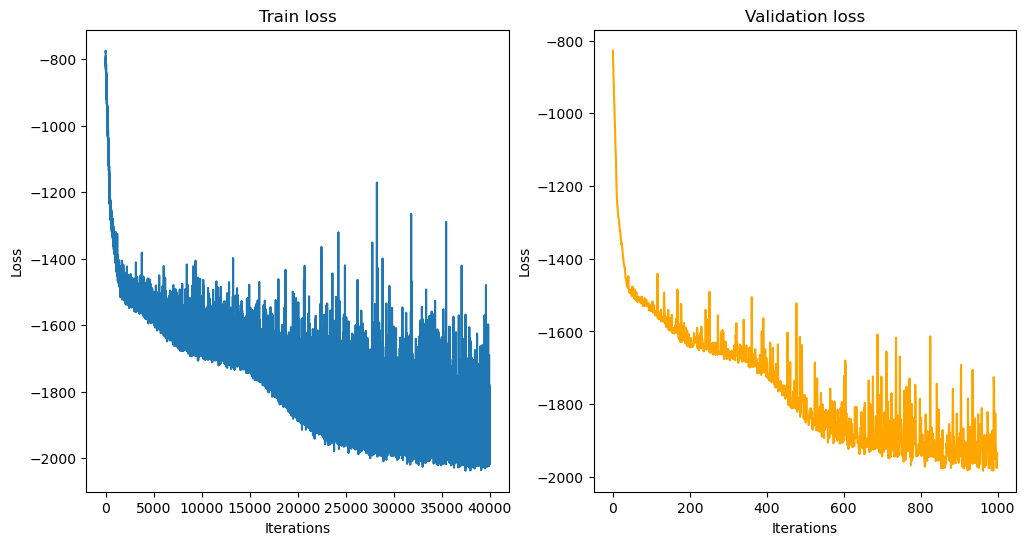

In [11]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# create model
BNN_model = BayesianNeuralNetwork(32, 128, device=device)
BNN_model = BNN_model.to(device)
optimizer = torch.optim.Adam(BNN_model.parameters(), lr=1e-4)

losses, log_priors, log_variational_posteriors, NLLs, val_losses = train_BNN(BNN_model, optimizer, trainloader, valloader, epochs=10000, model_name='BNN', val_every_n_epochs=10, device=device)

plot_loss(losses, val_losses)

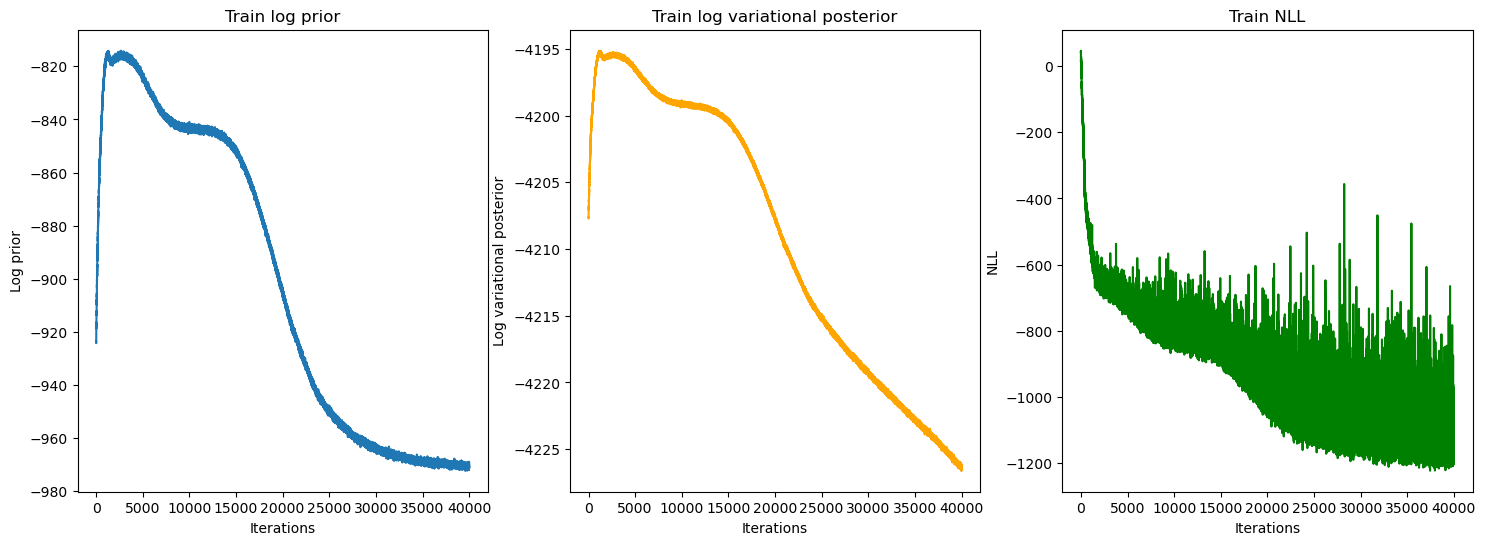

In [15]:
plot_log_probs(log_priors, log_variational_posteriors, NLLs)

In [16]:
model = torch.load("BNN.pt")

predictions = []
stds = []

for x_test, y_test in testloader:
    x_test, y_test = x_test.float(), y_test.float()
    with torch.no_grad():
        # output = model(x_test, inference=False)
        mu, rho = model(x_test, inference=False)
        # mu = output[:,0]
        # rho = output[:,1]
        sigma = model.get_sigma(rho)
        predictions.append(mu.cpu().detach().numpy())
        stds.append(sigma.cpu().detach().numpy())
        




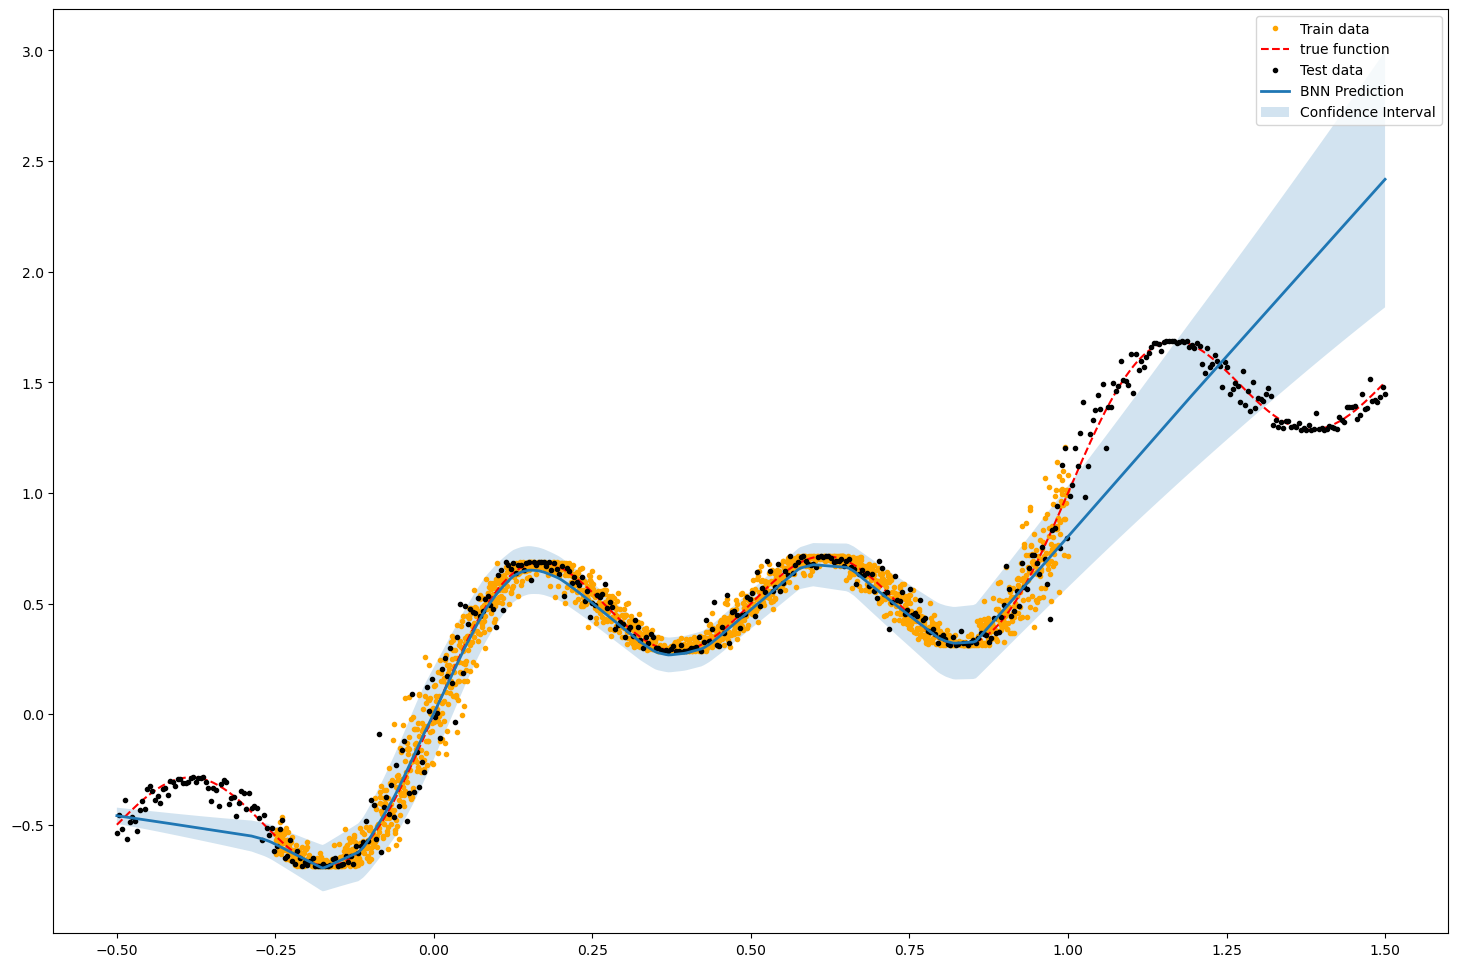

In [17]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(18,12))

### plot mimo ###
plt.plot(x_train, y_train, '.', label='Train data', color='orange')
plt.plot(x_test[:,0], line, '--', label='true function', color='red')
# plot test data
plt.plot(x_test[:,0], y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
plt.plot(x_test[:,0], predictions[0], '-', label=f'BNN Prediction', linewidth=2)
plt.fill_between(x_test[:,0], predictions[0] - 1.96*stds[0], predictions[0] + 1.96*stds[0], alpha=0.2, label=f'Confidence Interval')

plt.legend()

plt.show()


# Bayesian Convolutional layer

We start by implementing a Bayesian convolutional layer. Each value in the filter is represented by a Gaussian probability distribution.

In [13]:
class BayesianConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, device='cpu', pi=0.5, sigma1=torch.exp(torch.tensor(0)), sigma2=torch.tensor(0.3)):
        super().__init__()
        """
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        
        
        # initialise mu and rho parameters so they get updated in backpropagation
        # use *kernel_size instead of writing (_, _, kernel_size, kernel_size)
        self.weight_mu = nn.Parameter(torch.Tensor(in_channels, out_channels, *kernel_size).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(in_channels, out_channels, *kernel_size).uniform_(-5, -4))
        self.bias_mu = nn.Parameter(torch.Tensor(out_channels).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_channels).uniform_(-5, -4))

        # initialise priors
        self.weight_prior = ScaleMixturePrior(pi, sigma1, sigma2, device=device)
        self.bias_prior = ScaleMixturePrior(pi, sigma1, sigma2, device=device)

        # initialise variational posteriors
        self.weight_posterior = Gaussian(self.weight_mu.permute(1,0,2,3).to(device), self.weight_rho.permute(1,0,2,3).to(device), device=device)
        self.bias_posterior = Gaussian(self.bias_mu, self.bias_rho, device=device)

    def forward(self, x, inference=False):

        if inference:
            w = self.weight_posterior.mu
            b = self.bias_posterior.mu

            self.log_prior = 0.0
            self.log_variational_posterior = 0.0

        else:
            w = self.weight_posterior.rsample()
            b = self.bias_posterior.rsample()

            self.log_prior = self.weight_prior.log_prob(w) + self.bias_prior.log_prob(b)
            self.log_variational_posterior = self.weight_posterior.log_prob(w) + self.bias_posterior.log_prob(b)

        output = F.conv2d(x, w, b, self.stride, self.padding, self.dilation)

        # print("layer:", w.device, b.device, output.device, self.log_prior.device, self.log_variational_posterior.device)
        
        return output
        



We implement a Gaussian CNN with 2 conv layers and 3 linear layers.

In [39]:
class BayesianConvNeuralNetwork(nn.Module):
    def __init__(self, hidden_units1, hidden_units2, channels1, channels2, device="cpu"):
        super().__init__()
        """
        """
        self.conv1 = BayesianConvLayer(3, channels1, kernel_size=(3,3), padding=1, device=device)
        self.conv2 = BayesianConvLayer(channels1, channels2, kernel_size=(3,3), padding=1, device=device)
        self.layer1 = BayesianLinearLayer(channels2*32*32, hidden_units1, device=device)
        self.layer2 = BayesianLinearLayer(hidden_units1, hidden_units2, device=device)
        self.layer3 = BayesianLinearLayer(hidden_units2, 10, device=device)

        
        self.layers = [self.conv1, self.conv2, self.layer1, self.layer2, self.layer3]

        self.device = device

    def forward(self, x, inference=False):
        # print("x", x.device)
        x = F.relu(self.conv1(x, inference))
        x = F.relu(self.conv2(x, inference))
        x = x.reshape(x.size(0),-1)
        x = F.relu(self.layer1(x, inference))
        x = F.relu(self.layer2(x, inference))
        x = self.layer3(x, inference)
        probs = F.log_softmax(x, dim=1)
        x = torch.argmax(probs, dim=1)

        return x, probs
    
    def inference(self, x, inference=False, n_samples=1, n_classes=10):
        # log_probs : (n_samples, batch_size, n_classes)
        log_probs = np.zeros((n_samples, x.size(0), n_classes))

        for i in range(n_samples):
            pred, probs = self.forward(x, inference)
            log_probs[i] = probs.cpu().detach().numpy()

        mean_log_probs = log_probs.mean(0)
        mean_predictions = np.argmax(mean_log_probs, axis=1)

        return mean_predictions, mean_log_probs

    def compute_log_prior(self):
        model_log_prior = 0.0
        for layer in self.layers:
            if isinstance(layer, (BayesianLinearLayer, BayesianConvLayer)):
                model_log_prior += layer.log_prior
        return model_log_prior

    def compute_log_variational_posterior(self):
        model_log_variational_posterior = 0.0
        for layer in self.layers:
            if isinstance(layer, (BayesianLinearLayer, BayesianConvLayer)):
                model_log_variational_posterior += layer.log_variational_posterior
        return model_log_variational_posterior
    
    def compute_NLL(self, pred, target):
        loss_fn = torch.nn.NLLLoss(reduction='sum')
        NLL = loss_fn(pred, target)
        return NLL
    
    def get_sigma(self, rho):
        return torch.log1p(torch.exp(rho))

    def compute_ELBO(self, input, target, n_samples=1):
        log_priors = torch.zeros(n_samples) 
        log_variational_posteriors = torch.zeros(n_samples) 
        NLLs = torch.zeros(n_samples) 

        for i in range(n_samples):
            pred, probs = self.forward(input, inference=False)
            log_priors[i] = self.compute_log_prior()
            log_variational_posteriors[i] = self.compute_log_variational_posterior()
            NLLs[i] = self.compute_NLL(probs, target)

        log_prior = log_priors.mean(0)
        log_variational_posterior = log_variational_posteriors.mean(0)
        NLL = NLLs.mean(0)

        loss = ((log_variational_posterior - log_prior) / NUM_BATCHES) + NLL
 
        return loss, log_prior, log_variational_posterior, NLL



In [40]:
#load/download CIFAR10
# https://github.com/kuangliu/pytorch-cifar/issues/19 normalisation values
transform = transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

CIFAR_traindata = torchvision.datasets.CIFAR10(root="../data/", train=True, transform = transform, download=False)
CIFAR_train, CIFAR_val = torch.utils.data.random_split(CIFAR_traindata, [int(len(CIFAR_traindata)*0.9), int(len(CIFAR_traindata)*0.1)])
CIFAR_test = torchvision.datasets.CIFAR10(root="../data/", train=False, transform = transform, download=False)

CIFAR_trainloader = DataLoader(CIFAR_train, batch_size=500, shuffle=True, pin_memory=True)
CIFAR_valloader = DataLoader(CIFAR_val, batch_size=500, shuffle=True, pin_memory=True)
CIFAR_testloader = DataLoader(CIFAR_test, batch_size=500, shuffle=False, pin_memory=True)

In [41]:
# useful functions 🤖

def train_BNN_classification(model, optimizer, trainloader, valloader, epochs=500, model_name='C_BNN', val_every_n_epochs=10, device='cpu'):
    
    if device == 'cpu':
        print("Training on CPU")
    else:
        print("Cuda available, training on GPU")


    losses = []
    log_priors = []
    log_variational_posteriors = []
    NLLs = []

    val_losses = []
    val_log_priors = []
    val_log_variational_posteriors = []
    val_NLLs = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            model.train()

            x_, y_ = x_.float().to(device), y_.type(torch.LongTensor).to(device)

            optimizer.zero_grad()

            loss, log_prior, log_posterior, log_NLL = model.compute_ELBO(x_, y_)
            # print(loss)

            # print(loss.device, log_prior.device, log_posterior.device, log_NLL.device)
            
            loss.backward(retain_graph=False)
            optimizer.step()

            losses.append(loss.item()) 
            log_priors.append(log_prior.item())
            log_variational_posteriors.append(log_posterior.item())
            NLLs.append(log_NLL.item()) 

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float().to(device), val_y.type(torch.LongTensor).to(device)
                
                    val_loss, _ , _, _ = model.compute_ELBO(val_x, val_y)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, log_priors, log_variational_posteriors, NLLs, val_losses


def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')

    plt.show()


def plot_log_probs(log_priors, log_variational_posteriors, NLLs):

    fig, ax = plt.subplots(1,3, figsize=(18,6))

    ax[0].plot(log_priors, label='Train log prior')
    ax[0].set_title('Train log prior')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Log prior')

    ax[1].plot(log_variational_posteriors, label='Train log variational posterior', color='orange')
    ax[1].set_title('Train log variational posterior')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Log variational posterior')

    ax[2].plot(NLLs, label='Train NLL', color='green')
    ax[2].set_title('Train NLL')
    ax[2].set_xlabel('Iterations')
    ax[2].set_ylabel('NLL')

    plt.show()

Cuda available, training on GPU


  0%|          | 0/30 [00:00<?, ?it/s]

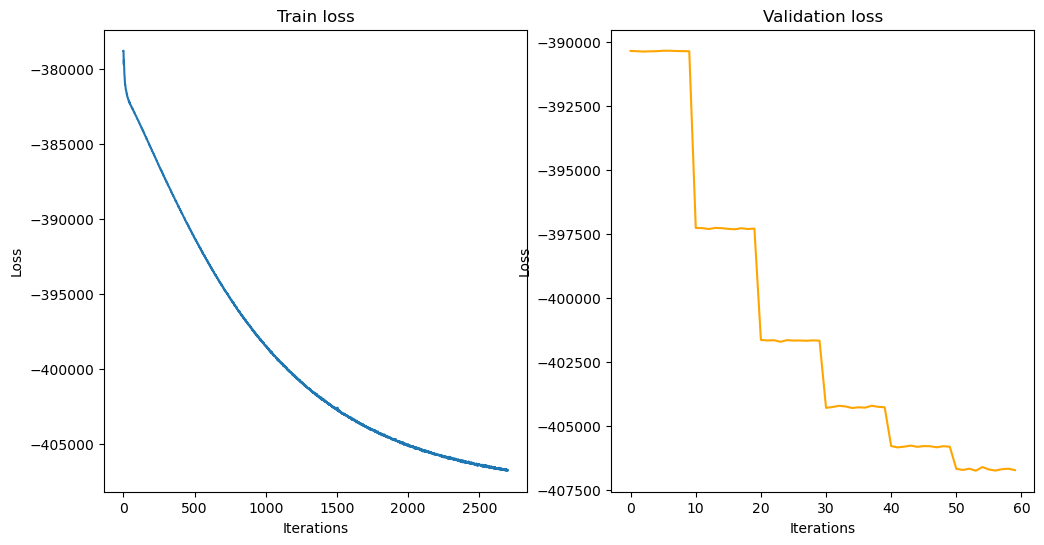

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

# create model
BNN_model = BayesianConvNeuralNetwork(hidden_units1=32, hidden_units2=128, channels1=32, channels2=64, device=device)
BNN_model = BNN_model.to(device)
optimizer = torch.optim.Adam(BNN_model.parameters(), lr=1e-4)

losses, log_priors, log_variational_posteriors, NLLs, val_losses = train_BNN_classification(BNN_model, optimizer, CIFAR_trainloader, CIFAR_valloader, epochs=30, model_name='C_BNN', val_every_n_epochs=5, device=device)

plot_loss(losses, val_losses)

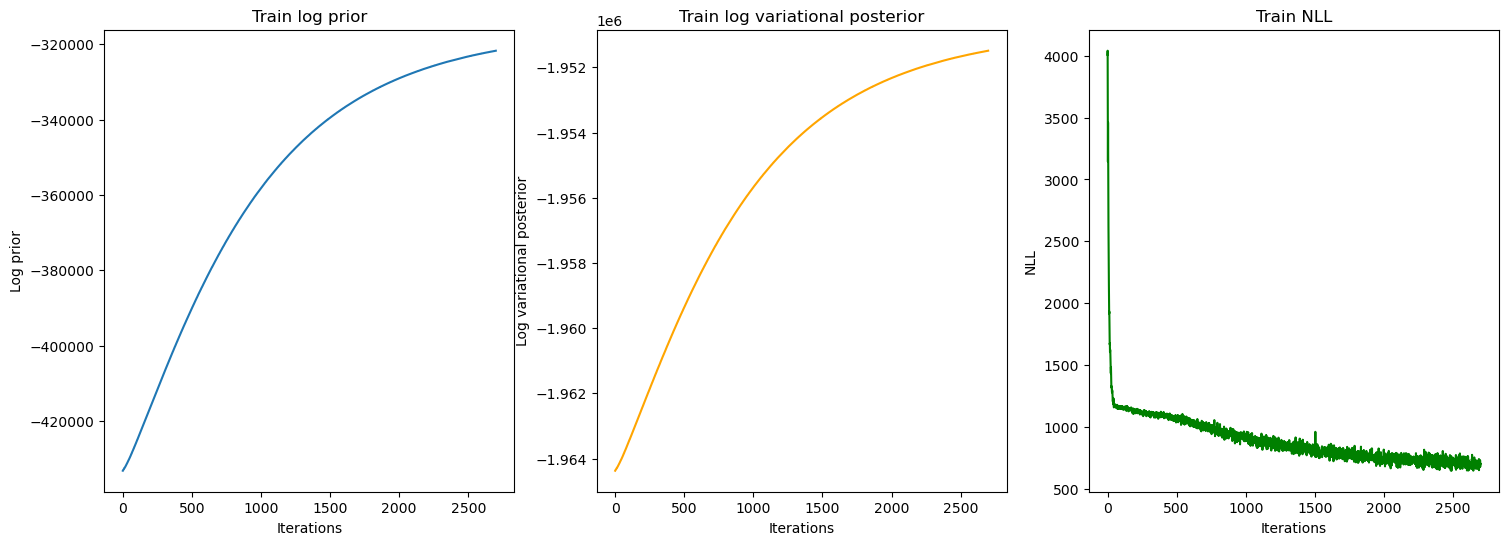

In [43]:
plot_log_probs(log_priors, log_variational_posteriors, NLLs)

In [47]:
model = torch.load("C_BNN.pt")

preds = []
log_probs = []
targets = []

for x_test, y_test in CIFAR_testloader:
    x_test, y_test = x_test.float().to(device), y_test.type(torch.LongTensor).to(device)
    with torch.no_grad():
        pred, probs = model.inference(x_test, inference=False, n_samples=10)
        preds.extend(pred)
        log_probs.extend(probs)
        targets.extend(y_test.cpu().detach().numpy())
        




In [48]:
# compute accuracy

accuracy = (np.array(preds) == np.array(targets)).sum() / len(preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4904
